In [ ]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from aind_vr_foraging_analysis.utils.parsing import data_access
import aind_vr_foraging_analysis.utils.plotting as plotting

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.patches as mpatches
# Plotting libraries
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FuncFormatter

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

color1='#d95f02'
color2='#1b9e77'
color3="#433abf"
color4='yellow'
odor_list_color = [color1, color2, color3, color4]
import matplotlib.lines as mlines

pdf_path = r'Z:\scratch\vr-foraging\sessions'
results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 5 - learning\results'

color_dict_label = {'InterSite': '#808080',
            'InterPatch': '#b3b3b3', 'PatchZ': '#d95f02',
            'PatchZA': '#d95f02', 'PatchZB': '#d95f02', 
            'PatchB': '#d95f02','PatchA': '#7570b3', 
            'PatchC': '#1b9e77',
            'Alpha-pinene': '#1b9e77', 
            'Methyl Butyrate': '#7570b3', 
            'Amyl Acetate': '#d95f02', 
            'Fenchone': '#7570b3', 
            'Dipropyl sulfide': '#7570b3',
            'Hexanal': '#1b9e77',
            'Pentyl acetate': '#d95f02',
            'S': color1,
            'D': color2,
            'N': color3,   
            'Do': color1,
            'None': color4
            }

label_dict = {**{
"InterSite": '#808080',
"InterPatch": '#b3b3b3'}, 
            **color_dict_label}
import os
import re
sns.set_context('talk')

In [ ]:
def average_velocity_odor_sites_reversal(all_epochs: pd.DataFrame, stream_data: pd.DataFrame, window: list = [-2,5], save=False):
    window = [-2, 5]
    odor_sites = all_epochs.loc[all_epochs['label'] == 'OdorSite']

    # Create figure and axes
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

    # Get trial summary
    trial_summary = plotting.trial_collection(
        odor_sites[['mouse', 'session', 'label', 'site_number', 'odor_label',
                    'last_visit','patch_number', 's_patch_label', 'odor_sites',
                    'block', 'is_choice', 'is_reward']],
        stream_data.encoder_data, aligned='index', window=window
    )

    # Filter once for site_number == 0
    summary_filtered = trial_summary[trial_summary['site_number'] == 0]

    # Labels and axes
    patch_labels = ['S', 'D', 'N']

    for i, block in enumerate(odor_sites.block.unique()):
        for ax, patch_label in zip(axes[i], patch_labels):
            data = summary_filtered[(summary_filtered['s_patch_label'] == patch_label)]
            sns.lineplot(
                data=data.loc[data['block'] == block],
                x='times',
                y='speed',
                hue='odor_sites',
                palette='coolwarm',
                linewidth=1,
                ax=ax,
                legend=False,
                errorbar='sd', 
                alpha = 0.6
            )
            try:
                odor_titles = data.loc[data['block'] == block]['odor_label'].unique()[0]
            except:
                odor_titles = data['odor_label'].unique()[0]
                
            ax.set_title(odor_titles, color = color_dict_label[patch_label])
            ax.set_ylabel("Velocity (cm/s)")
            ax.set_xlabel("Time after odor onset (s)", fontsize=10)
            ax.set_ylim(-13, 60)
            ax.set_yticks([0, 20, 40,60])
            ax.set_xlim(window)
            ax.hlines(8, window[0], window[1], color="black", linewidth=1, linestyles="dashed")
            ax.vlines(0, -13, 60, color="black", linewidth=1, linestyles="dashed")

    # Add manual legend
    handles = [
        plt.Line2D([0], [0], color=color_dict_label[label], label=label)
        for label in ['S','D','N']
    ]

    axes[1][-1].legend(handles=handles, title="Odor label", bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.despine()
    plt.suptitle(f"Velocity traces {data.mouse.unique()[0]}")
    plt.tight_layout()
    if save:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()  

In [ ]:
def segmented_raster_vertical(reward_sites: pd.DataFrame,
    color_dict_label: dict = {
        "Ethyl Butyrate": "#d95f02",
        "Alpha-pinene": "#1b9e77",
        "Amyl Acetate": "#7570b3"
    }, 
    save = False):
    
    patch_number = len(reward_sites.patch_number.unique())
    number_odors = len(reward_sites["odor_label"].unique())

    # Make second row proportional to the number of odors
    list_odors = []
    for odor in reward_sites.odor_label.unique():
        list_odors.append(
            reward_sites.loc[reward_sites.odor_label == odor].patch_number.nunique()
        )
    grid = (np.array(list_odors) / patch_number) * number_odors

    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(2, number_odors, width_ratios=grid)

    for index, row in reward_sites.iterrows():
        ax1 = plt.subplot(gs[0, 0:number_odors])
        if row["is_reward"] == 1 and row["is_choice"] == True:
            color = "steelblue"
        elif row["is_reward"] == 0 and row["is_choice"] == True:
            color = "pink"
            if row["reward_probability"] <= 0:
                color = "crimson"
        else:
            if row["reward_probability"] <= 0:
                color = "black"
            else:
                color = "lightgrey"

        # ax1.barh(int(row['patch_number']), left=row['site_number'], height=1, width=1, color=color, edgecolor='darkgrey', linewidth=0.5)
        ax1.bar(
            int(row["patch_number"]),
            bottom=row["site_number"],
            height=1,
            width=1,
            color=color,
            edgecolor="darkgrey",
            linewidth=0.5,
        )
        ax1.set_xlim(-1, max(reward_sites.patch_number) + 1)          
        ax1.set_xlabel("Patch number")
        ax1.set_ylabel("Site number")

        # ax1.bar(int(row['patch_number']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
        ax1.scatter(
            row["patch_number"],
            -0.25,
            color=color_dict_label[row["odor_label"]],
            marker="^",
            s=35,
            edgecolor="black",
            linewidth=0.0,
        )

    if reward_sites.block.nunique() > 1:
        change_index = reward_sites[reward_sites.block.diff() != 0]['patch_number'].values[1]
        ax1.axvline(change_index-0.5, color='black', linestyle='--', label='Change')
            
    odors = []
    for odor in reward_sites["s_patch_label"].unique():
        odors.append(
            mpatches.Patch(
                color=color_dict_label[odor],
                label=(
                    str(odor)
                ),
            )
        )

    label_2 = mpatches.Patch(color="steelblue", label="Harvest, rewarded")
    label_3 = mpatches.Patch(color="crimson", label="Harvest, no reward, depleted")
    label_4 = mpatches.Patch(color="lightgrey", label="Leave, not depleted")
    label_5 = mpatches.Patch(color="black", label="Leave, depleted")
    label_6 = mpatches.Patch(color="pink", label="Harvest, no reward, probabilitic")

    odors.extend([label_2, label_3, label_6, label_4, label_5])
    ax1.set_ylim(-1, max(reward_sites.site_number) + 1)

    # Create subplots dynamically in the bottom row (row index 1)
    unique_patches = reward_sites["odor_label"].unique()
    axes = [plt.subplot(gs[1, i]) for i in range(number_odors)]

    # Now loop over each odor and axis
    for ax, odor_label in zip(axes, unique_patches):
        selected_sites = reward_sites.loc[reward_sites.odor_label == odor_label]
        previous_active = 0
        value = 0
        blocks = selected_sites['block'].drop_duplicates().values
        for i in range(len(blocks) - 1):
            # Find where the transition happens
            idx = selected_sites[selected_sites['block'] == blocks[i]].patch_number.nunique()
            ax.axvline(idx + 0.5, color='black', linestyle='--', label='Block Change' if i == 0 else None)

            # Label each side of the transition
            for offset, block in zip([-1, 1], [blocks[i], blocks[i + 1]]):
                labels = selected_sites[selected_sites['block'] == block]['s_patch_label'].unique()
                if len(labels):
                    ax.text(idx + offset, y=3, s=labels[0], ha='right' if offset < 0 else 'left')

        for index, row in selected_sites.iterrows():
            # Choose the color of the site
            if row["is_reward"] == 1 and row["is_choice"] == True:
                color = "steelblue"
            elif row["is_reward"] == 0 and row["is_choice"] == True:
                color = "pink"
                if row['s_patch_label'] == 'N':
                    color = "crimson"
                elif row['s_patch_label'] == 'D' and row['site_number'] >= 3:
                    color = "crimson"
                elif row['s_patch_label'] == 'S' and row['site_number'] >= 1:
                    color = "crimson"
            else:
                if row['s_patch_label'] == 'N':
                    color = "black"
                elif row['s_patch_label'] == 'D' and row['site_number'] >= 3:
                    color = "black"
                elif row['s_patch_label'] == 'S' and row['site_number'] >= 1:
                    color = "black"
                else:
                    color = "lightgrey"

            ax.set_title(odor_label)

            if row["patch_number"] != previous_active:
                value += 1
                previous_active = row["patch_number"]
            ax.bar(
                value,
                bottom=row["site_number"],
                height=1,
                width=1,
                color=color,
                edgecolor="darkgrey",
                linewidth=0.5,
            )
            ax.set_xlim(-1, selected_sites.patch_number.nunique() + 1)
            ax.set_ylim(-0.5, reward_sites.site_number.max() + 1)
            ax.set_ylabel("Site number")
            ax.set_xlabel("Patch number")

    fig.tight_layout()
    plt.legend(handles=odors, loc='best', bbox_to_anchor=(0.75, 1), fontsize=12, ncol=1)
    sns.despine()
    if save:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()  


In [ ]:
def average_velocity_traces_reversal(all_epochs: pd.DataFrame, stream_data, window: list = [-2,5], save=False):
    odor_sites = all_epochs.loc[all_epochs['label'] == 'OdorSite']

    # Create figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), sharex=True, sharey=True)

    # Get trial summary
    trial_summary = plotting.trial_collection(
        odor_sites[['mouse', 'session', 'label', 'site_number', 'odor_label',
                    'last_visit','patch_number', 's_patch_label', 'odor_sites',
                    'block', 'is_choice', 'is_reward']],
        stream_data.encoder_data, aligned='index', window=window
    )

    # Filter once for site_number == 0
    summary_filtered = trial_summary[trial_summary['site_number'] == 0]

    # Labels and axes
    patch_labels = ['S', 'D', 'N']

    for ax, patch_label in zip(axes, patch_labels):
        data = summary_filtered[summary_filtered['s_patch_label'] == patch_label]
        
        sns.lineplot(
            data=data,
            x='times',
            y='speed',
            hue='odor_label',
            style='block',
            palette=color_dict_label,
            ax=ax,
            legend=False,
            errorbar='sd', 
            alpha=0.6,
        )
        
        odor_titles = data['odor_label'].unique()[0]
        # title = ', '.join(odor_titles) if len(odor_titles) > 0 else patch_label
        ax.set_title(odor_titles)

        ax.set_ylabel("Velocity (cm/s)")
        ax.set_xlabel("Time after odor onset (s)")
        ax.set_ylim(-13, 60)
        ax.set_yticks([0, 20, 40, 60])
        ax.set_xlim(window)
        ax.hlines(8, window[0], window[1], color="black", linewidth=1, linestyles="dashed")
        ax.vlines(0, -13, 60, color="black", linewidth=1, linestyles="dashed")

    # Add manual legend
    handles = [
        plt.Line2D([0], [0], color=color_dict_label[label], label=label)
        for label in ['S','D','N']
    ]
    block_handles = [
        mlines.Line2D([], [], color='black', linestyle="solid", label=f"Block 0"),
        mlines.Line2D([], [], color='black', linestyle="dashed", label=f"Block 1")
    ]

    axes[-1].legend(handles=handles + block_handles, title="Odor label", bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.despine()
    plt.suptitle(f"Velocity traces {data.mouse.unique()[0]}")
    plt.tight_layout()
    if save:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()  


In [ ]:
def get_condition_code(text):
    if 'delayed' in text:
        return 'D'
    elif 'single' in text:
        return 'S'
    elif 'no_reward' in text or 'noreward' in text:
        return 'N'
    elif 'double' in text:
        return 'Do'
    else:
        return text

## **Compute a summary of reversal and experimental history for this group of mice**

In [ ]:
import aind_vr_foraging_analysis.data_io as data_io

def parse_summary_session(session_path):
    df = {}
    data = {}
    # Work around the change in the folder structure
    if "behavior" in os.listdir(session_path):
        session_path_behavior = session_path / "behavior"
    else:
        session_path_behavior = session_path
        
    if "other" in os.listdir(session_path):
        session_path_config = session_path / "other"
    else:
        session_path_config = session_path
        
        # Load config old version
    if "Logs" in os.listdir(session_path_behavior):
        data["config"] = data_io.ConfigSource(path=session_path_behavior / "Logs", name="config", autoload=True)
        
    rig = data['config'].streams.rig_input.data
    task_logic = data['config'].streams.tasklogic_input.data
    
    df['rig'] = rig['rig_name']
    try:
        df['stage'] = task_logic['stage_name']
    except:
        df['stage'] = 'no_stage'
    df['VAST'] = str(session_path)[10:]
    df['s3'] = str(session_path)[27:]
    return df

In [ ]:
date_string = "2025-5-1"
mouse_list = ['789914', '789915', '789923', '789917', '789909', '789910', '789907', '789903', '789924', '789925', '789926']

df = pd.DataFrame(columns=['mouse', 'stage', 'reversal', 'start', 'stop', 'VAST', 's3'])
for mouse in mouse_list:
    print(f"Loading {mouse}...")
    session_paths = data_access.find_sessions_relative_to_date(
        mouse=mouse,
        date_string=date_string,
        when='on_or_after',
    )

    for session_path in session_paths:
        new_row = parse_summary_session(session_path)
        new_row['reversal'] = 'reversal' in new_row['stage']
        match = re.search(r'set(\d+)', new_row['stage'])
        new_row['start'] = match.group(1) if match else None
        if new_row['reversal']:
            match = re.search(r'reversal_set(\d+)', new_row['stage'])
            new_row['stop'] = match.group(1) if match else None
        new_row['mouse'] = mouse
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

### ___________________________________________________________________________________________________________________

## **Run summary metrics for several mice on a given reversal day**

In [ ]:
mouse_list = ['754574', '789903','789907','789909', '789910', '789914', '789915', '789917', '789923', '789924', '789925', '789926']

In [ ]:
reversal = 6

In [590]:
# Define reversal dates
reversal_dates = {
    1: '2025-05-13',
    2: '2025-06-03',
    3: '2025-06-10',
    4: '2025-06-19',
    5: '2025-06-24',
    6: '2025-06-30',
    7: '2025-07-01',
    8: '2025-07-02',
    9: '2025-07-03',
    10: '2025-07-04',
    11: '2025-07-05'
}

# Generalization date (if needed separately)
generalization = pd.to_datetime('2025-06-13')

# Get the reversal date for the current value
reversal_date = pd.to_datetime(reversal_dates.get(reversal))

days = 10

# Compute the date strings
date_string = (reversal_date - pd.Timedelta(days=days)).strftime('%Y-%m-%d')
end_date_string = (reversal_date + pd.Timedelta(days=days)).strftime('%Y-%m-%d')

# date_string = "2025-08-02"
# end_date_string = "2025-08-8"

In [527]:
def align_block_change_after(all_epochs: pd.DataFrame):
    all_epochs = all_epochs.copy()
    block = None
    patch_number = None
    countN = countD = countS = 0

    for index, row in all_epochs.iterrows():
        # reset at new block
        if row['block_count'] != block:
            block = row['block_count']
            patch_number = None
            countN = countD = countS = 0

        # if we’re in a new patch, bump the right counter
        if row['patch_number'] != patch_number:
            patch_number = row['patch_number']
            if row['patch_label'] == 'N':
                countN += 1
            elif row['patch_label'] == 'D':
                countD += 1
            elif row['patch_label'] == 'S':
                countS += 1

        # assign the current count (no extra increment)
        if row['patch_label'] == 'N':
            all_epochs.at[index, 'patch_align'] = countN
        elif row['patch_label'] == 'D':
            all_epochs.at[index, 'patch_align'] = countD
        elif row['patch_label'] == 'S':
            all_epochs.at[index, 'patch_align'] = countS
            
    block = None
    patch_number = None
    countN = countD = countS = 0

    for index, row in all_epochs.iloc[::-1].iterrows():
        # reset at new block
        if row['block_count'] != block:
            block = row['block_count']
            patch_number = None
            countN = countD = countS = 0

        # if we’re in a new patch, bump the right counter
        if row['patch_number'] != patch_number:
            patch_number = row['patch_number']
            if row['patch_label'] == 'N':
                countN += -1
            elif row['patch_label'] == 'D':
                countD += -1
            elif row['patch_label'] == 'S':
                countS += -1

        # assign the current count (no extra increment)
        if row['patch_label'] == 'N':
            all_epochs.at[index, 'patch_align_r'] = countN
        elif row['patch_label'] == 'D':
            all_epochs.at[index, 'patch_align_r'] = countD
        elif row['patch_label'] == 'S':
            all_epochs.at[index, 'patch_align_r'] = countS
            
    return all_epochs

In [591]:
sum_df = pd.DataFrame()
summary_df = pd.DataFrame()

for mouse in mouse_list:
    with PdfPages(os.path.join(results_path, f"{mouse}_reversal_{date_string}.pdf")) as pdf:
        session_paths = data_access.find_sessions_relative_to_date(
            mouse=mouse,
            date_string=date_string,
            when='between', 
            end_date_string=end_date_string,
        )
        session_n = 0
        for session_path in session_paths:
            print(mouse, session_path)
            # try:
            all_epochs, stream_data, data = data_access.load_session(
                session_path
            )
            # except:
            #     print(f"Error loading {session_path.name}")
            #     continue
            all_epochs['mouse'] = mouse
            all_epochs['session'] = session_path.name[7:17]
            all_epochs['session_n'] = session_n
            
            try:
                all_epochs['block'] = all_epochs['patch_label'].str.extract(r'set(\d+)').astype(int)
            except ValueError: 
                all_epochs['block'] = 0

            # Apply function
            all_epochs['patch_label'] = all_epochs['patch_label'].apply(get_condition_code)
            all_epochs['patch_number']+=1
            
            # Remove segments where the mouse was disengaged
            last_engaged_patch = all_epochs['patch_number'][all_epochs['skipped_count'] >= 15].min()
            if pd.isna(last_engaged_patch):
                last_engaged_patch = all_epochs['patch_number'].max()
                
            all_epochs['engaged'] = all_epochs['patch_number'] <= last_engaged_patch  
            all_epochs['block_change'] = all_epochs['block'].diff().abs()
            all_epochs['block_change'] = np.where(all_epochs['block_change'] != 0, 1, 0)
            all_epochs['stage'] = data['config'].streams.tasklogic_input.data['stage_name']
            all_epochs['block_count'] = all_epochs.block_change.cumsum()

            all_epochs = align_block_change_after(all_epochs)

            # plotting.segmented_raster_vertical_reversal(all_epochs.loc[all_epochs['label'] == 'OdorSite'],
            #     color_dict_label = color_dict_label, 
            #     save=pdf)
            # average_velocity_traces_reversal(all_epochs, stream_data, save=pdf)
            # average_velocity_odor_sites_reversal(all_epochs, stream_data, save=pdf)   
                     
            fig, ax = plt.subplots(1, 1, figsize=(10, 4))
            # change_index = plot_df[plot_df.block.diff() != 0]['patch_number'].values[1]
            plot_df = all_epochs.groupby(['mouse', 'session', 'block', 'patch_number', 'patch_label', 'odor_label']).agg({'is_choice' : 'sum'}).reset_index()
            sns.lineplot(data=plot_df, x='patch_number', y='is_choice', hue='patch_label', palette=color_dict_label, legend=False, ax=ax, alpha=0.4)
            sns.scatterplot(data=plot_df, x='patch_number', y='is_choice', hue='patch_label', style='odor_label', palette=color_dict_label, legend=False, ax=ax)
            
            if plot_df.block.nunique() > 1:
                change_index = plot_df[plot_df.block.diff() != 0]['patch_number'].values[1]
                ax.axvline(change_index, color='black', linestyle='--', label='Change')
                
            ax.set_title(mouse)
            ax.set_xlabel('Patch number')
            ax.set_ylabel('Number of stops')
            ax.hlines(0, xmin=0, xmax=plot_df.patch_number.nunique(), color='black', linestyle='--') 
            sns.despine()
            pdf.savefig(fig)
            plt.close(fig)
    
            # Compute total and visited patches in a single step
            patch_total = all_epochs.groupby('patch_label')['patch_number'].nunique()
            visited_filter = (all_epochs.site_number == 0) & (all_epochs.is_choice == 1)
            patch_visited = all_epochs.loc[visited_filter].groupby('patch_label')['patch_number'].nunique()

            # Combine into one dataframe
            patch_df = pd.DataFrame({
                'patch_number': patch_total,
                'visited': patch_visited
            }).fillna(0)  # Fill NaNs for labels that were never visited

            
            patch_df['fraction_visited'] = patch_df['visited'] / patch_df['patch_number']
            patch_df['mouse'] = mouse
            patch_df['session'] = session_path.name[7:17]
            patch_df['session_n'] = session_n
            session_n += 1
            
            sum_df = pd.concat([patch_df.reset_index(), sum_df])
            
            # all_epochs = all_epochs.loc[all_epochs['engaged'] == 1]
            summary_df = pd.concat([all_epochs, summary_df])

# Ensure session column is datetime
summary_df['session_date'] = pd.to_datetime(summary_df['session'])

# Compute alignment
summary_df['reversal_align'] = (summary_df['session_date'] - reversal_date).dt.days

summary_df.drop(columns=['session_date'], inplace=True)

754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-16T160550Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-17T171419Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-18T161946Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-19T172642Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-20T173315Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-23T163117Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-24T164654Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-25T170103Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\754574_2025-06-26T171732Z
Reward functions from software events
754574 Z:\scratch\vr-foraging\data\754574\7545

In [ ]:
summary_df = summary_df.loc[summary_df['mouse'] != '789909']

In [529]:
summary_df.stage.unique()

array(['learning_task2_set5_reversal_set0', 'learning_task2_set5',
       'learning_task_set4_reversal_set5', 'learning_task2_set4',
       'learning_task2_set4_reversal_set0',
       'learning_task_set5_reversal_set4',
       'learning_task2_set4double_reversal_set0double',
       'learning_task2_set4_double', 'learning_task2_set5_double'],
      dtype=object)

In [593]:
block_align = 1
stage = 'learning_task_set5_reversal_set4'
plot = summary_df.loc[((summary_df['stage'] == stage) & (summary_df['patch_align'] <= 20) & (summary_df['block_count'] == block_align+1))].groupby(['mouse','session', 'odor_label', 'patch_label', 'patch_align']).agg({'is_choice' : 'sum'}).reset_index()

plot_r = summary_df.loc[((summary_df['stage'] == stage) & (summary_df['patch_align_r'] >= -5) & (summary_df['block_count'] == block_align))].groupby(['mouse','session', 'odor_label', 'patch_label', 'patch_align_r']).agg({'is_choice' : 'sum'}).reset_index()

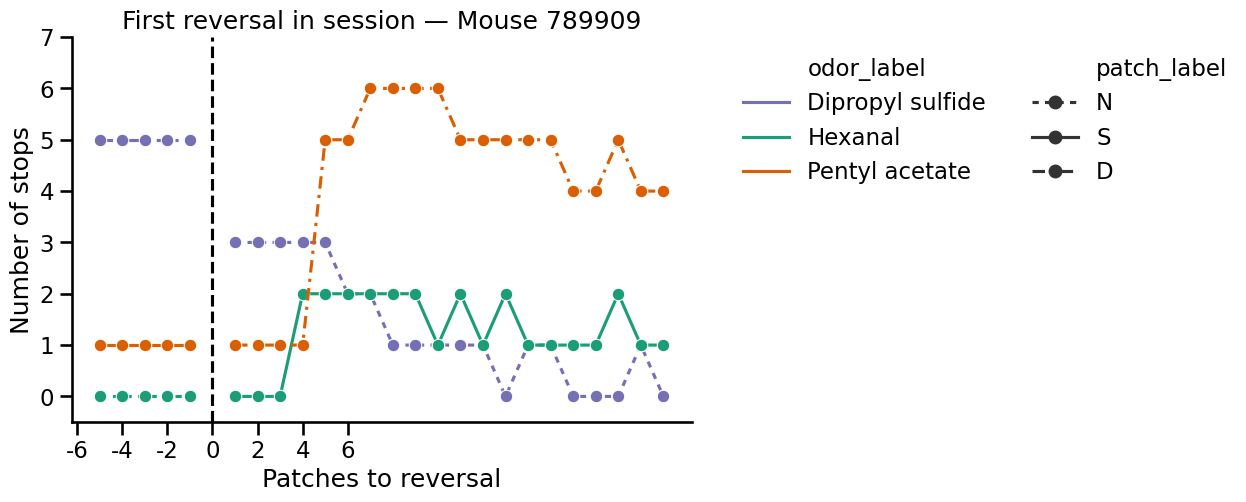

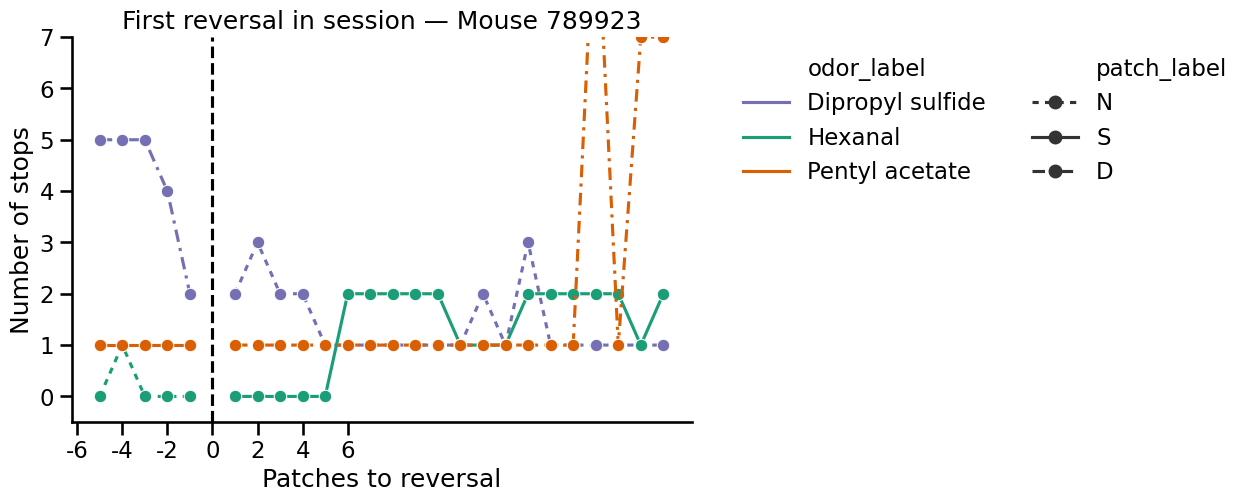

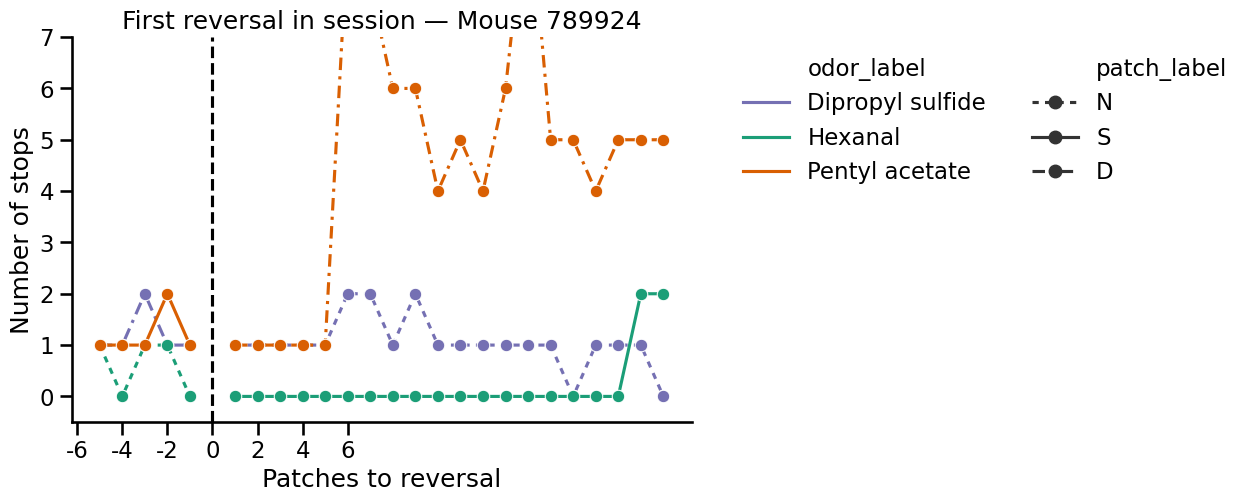

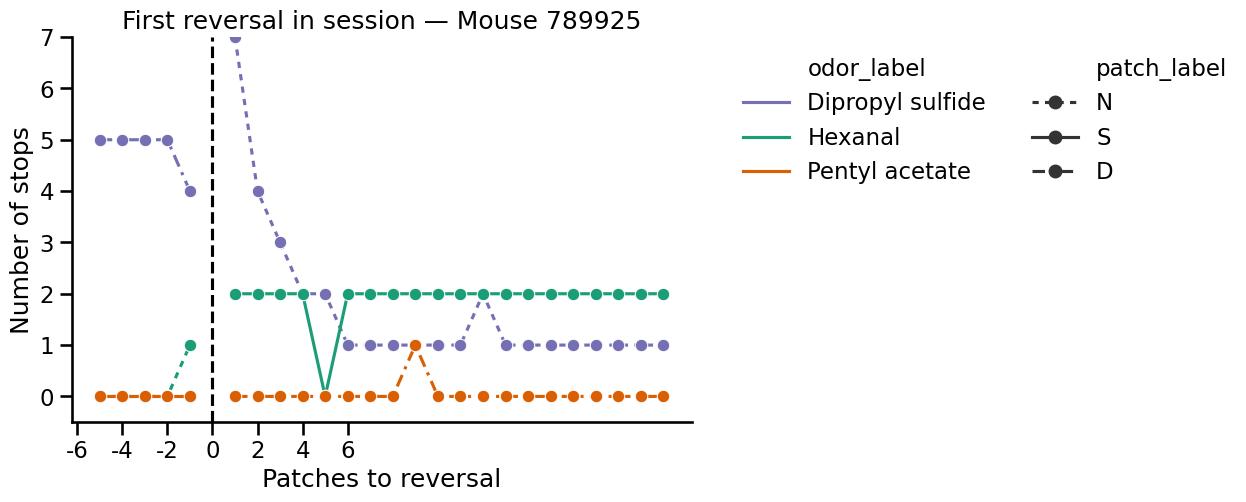

In [551]:
mice = plot["mouse"].unique()

for mouse in mice:
    fig, ax = plt.subplots(figsize=(8, 5))

    # forward
    sns.lineplot(
        data=plot.query("mouse == @mouse"),
        x="patch_align",
        y="is_choice",
        hue="odor_label",
        style="patch_label",
        palette=color_dict_label,
        dashes=dash,
        markers='o',

        ax=ax
    )

    # reversal
    sns.lineplot(
        data=plot_r.query("mouse == @mouse"),
        x="patch_align_r",
        y="is_choice",
        hue="odor_label",
        style="patch_label",
        palette=color_dict_label,
        dashes=dash,
        markers='o',
        ax=ax,
        legend=False
    )

    sns.despine()
    ax.set_ylim(-0.5, 7)
    ax.set_ylabel("Number of stops")
    ax.set_xlabel("Patches to reversal")
    ax.set_xticks([-6, -4, -2, 0, 2, 4, 6])
    ax.set_xticklabels([-6, -4, -2, 0, 2, 4, 6])
    ax.axvline(0, color="black", linestyle="--")

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2, frameon=False)
    ax.set_title(f"First reversal in session — Mouse {mouse}")

    plt.show()


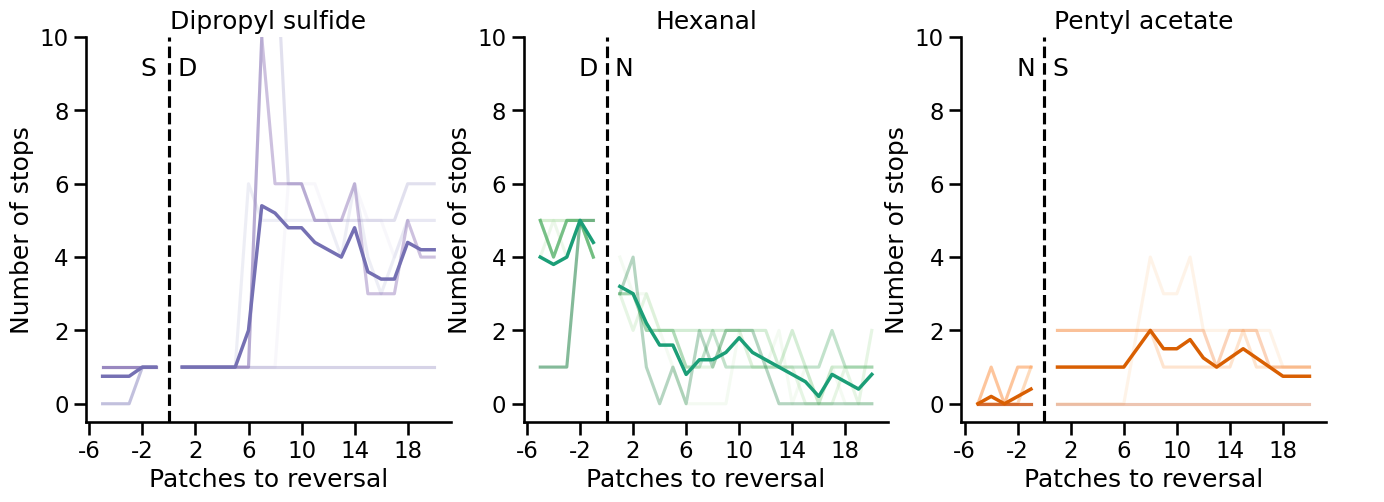

<Figure size 640x480 with 0 Axes>

In [594]:
odor_labels = plot["odor_label"].unique()
palettes = {'Hexanal': 'Greens', 'Pentyl acetate': 'Oranges', 'Dipropyl sulfide': 'Purples'}
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for odor, ax in zip(odor_labels, axes.flatten()):

    # --- Individual animals (faint lines) ---
    sns.lineplot(
        data=plot.query("odor_label == @odor"),
        x="patch_align",
        y="is_choice",
        hue="mouse",
        palette=palettes[odor],
        alpha=0.3,                   # faint lines
        legend=False,
        ax=ax
    )
    sns.lineplot(
        data=plot_r.query("odor_label == @odor"),
        x="patch_align_r",
        y="is_choice",
        hue="mouse",
        palette=palettes[odor],
        alpha=0.5,
        legend=False,
        ax=ax
    )

    # --- Mean line across animals ---
    mean_forward = (
        plot.query("odor_label == @odor")
        .groupby(["patch_align", "patch_label"], as_index=False)["is_choice"].mean()
    )
    mean_reverse = (
        plot_r.query("odor_label == @odor")
        .groupby(["patch_align_r", "patch_label"], as_index=False)["is_choice"].mean()
        .rename(columns={"patch_align_r": "patch_align"})
    )

    sns.lineplot(
        data=mean_forward,
        x="patch_align",
        y="is_choice",
        linewidth=2.5,
        color=color_dict_label[odor],
        ax=ax,
    )
    sns.lineplot(
        data=mean_reverse,
        x="patch_align",
        y="is_choice",
        linewidth=2.5,
        color=color_dict_label[odor],
        ax=ax,
    )

    # --- Formatting ---
    sns.despine()
    ax.text(0.25, 0.9, f"{plot.loc[plot['odor_label'] == odor]['patch_label'].values[0]}", transform=ax.transAxes)
    ax.text(0.15, 0.9, f"{plot_r.loc[plot_r['odor_label'] == odor]['patch_label'].values[0]}", transform=ax.transAxes)

    ax.set_ylim(-0.5, 10)
    ax.set_ylabel("Number of stops")
    ax.set_title(odor)
    ax.set_xlabel("Patches to reversal")
    ax.set_xticks(np.arange(-6, 22, 4))
    ax.set_xticklabels(np.arange(-6, 22, 4))
    ax.axvline(0, color="black", linestyle="--")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)

plt.show()
plt.savefig(os.path.join(results_path, f"all_mice_{stage}_by_odor.pdf"))

In [589]:
plot.mouse.nunique()

5

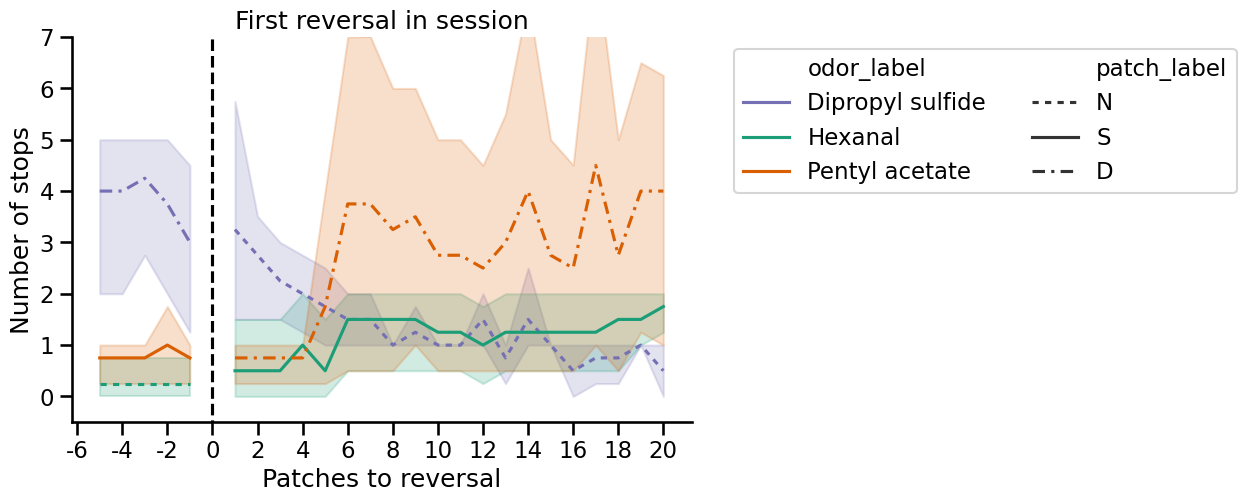

In [556]:
dash = {
    "S": "",        # solid
    "N": (2, 2),    # dashed
    "D": (4, 2, 1, 2),  # dash-dot
}

fig = plt.figure(figsize=(8, 5))
sns.lineplot(data=plot, x='patch_align', y='is_choice', hue='odor_label', style='patch_label',  palette=color_dict_label, dashes=dash)
sns.lineplot(data=plot_r, x='patch_align_r', y='is_choice', hue='odor_label', style='patch_label', palette=color_dict_label, legend=False, dashes=dash)
sns.despine()
plt.ylim(-0.5
         , 7)
plt.ylabel('Number of stops')
plt.xlabel('Patches to reversal')
plt.xticks(np.arange(-6, 22, 2), np.arange(-6, 22, 2))
plt.vlines(0, -1, 10, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.title(f"First reversal in session")


plt.savefig(os.path.join(results_path, f"reversal_block{block_align}_learning_task3_set3_reversal_set0_repeat2.svg"), bbox_inches='tight')

In [ ]:
summary_df = summary_df.loc[(summary_df['engaged'] == 1)|(summary_df['patch_number'] > 40)]

### **Compare the before and after of reversals in segmented raster plot**

In [ ]:
def before_after_reversal(mouse_df: pd.DataFrame, save=False):
    # def segmented_raster_vertical_comparison(
    #     session1: pd.DataFrame,
    #     session2: pd.DataFrame,
    #     color_dict_label: dict = {
    #         "Ethyl Butyrate": "#d95f02",
    #         "Alpha-pinene": "#1b9e77",
    #         "Amyl Acetate": "#7570b3"
    #     },
    #     save=False
    # ):
    sessions = []

    # Get unique reversal_align values, sorted
    align_values = sorted(mouse_df['reversal_align'].dropna().unique())

    # Loop through each and store the corresponding DataFrame slice
    for val in align_values:
        session_df = mouse_df.loc[mouse_df['reversal_align'] == val]
        sessions.append(session_df)
        
    number_odors = max(
        len(df["odor_label"].unique()) for df in sessions
    )

    # Collect unique odors from both sessions
    all_odors = sorted(set(sessions[0]["odor_label"].unique()).union(sessions[0]["odor_label"].unique()))
    number_odors = len(all_odors)
    max_site_number = max(df["site_number"].max() for df in sessions)

    fig = plt.figure(figsize=(4*len(sessions), 4 * number_odors))
    gs = GridSpec(number_odors, len(sessions))

    for row_idx, odor in enumerate(mouse_df["odor_label"].unique()):
        for col_idx, reward_sites in enumerate(sessions):
            
                ax = plt.subplot(gs[row_idx, col_idx])
                selected_sites = reward_sites.loc[reward_sites.odor_label == odor]
                previous_active = 0
                value = 0

                blocks = selected_sites['block'].drop_duplicates().values
                for i in range(len(blocks) - 1):
                    idx = selected_sites[selected_sites['block'] == blocks[i]].patch_number.nunique()
                    ax.axvline(idx + 0.5, color='black', linestyle='--', label='Block Change' if i == 0 else None)

                    for offset, block in zip([-0.5, 1], [blocks[i], blocks[i + 1]]):
                        labels = selected_sites[selected_sites['block'] == block]['s_patch_label'].unique()
                        if len(labels):
                            ax.text(idx + offset, y=max_site_number + 1, s=labels[0],
                                    ha='right' if offset < 0 else 'left', color=color_dict_label[labels[0]])

                for _, row in selected_sites.iterrows():
                    # Color assignment
                    if row["is_reward"] == 1 and row["is_choice"]:
                        color = "steelblue"
                    elif row["is_reward"] == 0 and row["is_choice"]:
                        color = "pink"
                        if row["reward_probability"] <= 0 or row["reward_available"] <= 0 or row["reward_amount"] <= 0:
                            color = "crimson"
                    else:
                        color = "black" if row["reward_probability"] <= 0  else "lightgrey"

                    if row["patch_number"] != previous_active:
                        value += 1
                        previous_active = row["patch_number"]

                    ax.bar(
                        value,
                        bottom=row["site_number"],
                        height=1,
                        width=1,
                        color=color,
                        edgecolor="darkgrey",
                        linewidth=0.5,
                    )

                ax.set_title(odor)
                ax.set_xlim(-1, selected_sites.patch_number.nunique() + 1)
                ax.set_ylim(-0.5, max_site_number + 2)
                if col_idx == 0:
                    ax.set_ylabel("Site number")
                if row_idx == 1:
                    ax.set_xlabel("Patch number")

    fig.tight_layout()
    sns.despine()

    if save:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()


In [ ]:
rev_df = summary_df.loc[(summary_df['reversal_align'] >= -2)&(summary_df['reversal_align'] <= 3)]
for mouse in rev_df.mouse.unique():
    with PdfPages(os.path.join(results_path, f"{mouse}_before_after_reversal_{reversal}.pdf")) as pdf:
        mouse_df = summary_df.loc[summary_df['mouse'] == mouse]
        before_after_reversal(mouse_df, save=pdf)

## **Optimality plot**

In [ ]:
summary_df = summary_df.loc[summary_df['engaged'] == True]

In [ ]:
group1 = ['789925', '789909', '789914', '789907', '789917']
group2 = ['789926', '789903', '789910', '789915', '789924', '789923']

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharex=True, sharey=True)
test_df = summary_df.groupby(['mouse', 'reversal_align', 'patch_number','block','s_patch_label']).agg({'site_number': 'max'}).reset_index()
test_df['optimal'] = np.where(test_df['s_patch_label'] == 'N', 0, 0)
test_df['optimal'] = np.where(test_df['s_patch_label'] == 'D', 4, test_df['optimal'])
test_df['optimal'] = np.where(test_df['s_patch_label'] == 'S', 1, test_df['optimal'])
test_df['diff_optimal'] = test_df['site_number'] - test_df['optimal']
test_df = test_df.groupby(['mouse', 'reversal_align', 's_patch_label']).agg({'diff_optimal': 'mean'}).reset_index()

for ax, group in zip(axes.flatten(), [group1, group2]):
    
    sns.boxplot(
        data=test_df.loc[
            (test_df['mouse'].isin(group))
        ],
        x='reversal_align',
        y='diff_optimal',
        hue='s_patch_label',
        ax=ax,
        palette=color_dict_label, 
        dodge=True,
    )
    # ax.set_ylim(-4, 2)
    ax.set_xlabel('Reversal alignment (days)')
    ax.set_ylabel('Difference from optimal stops')
    ax.hlines(0, xmin=-1, xmax = 4, color='black', linestyle='--', linewidth=1)
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(results_path, f'reversal_optimal_stops_reversal_{reversal}.pdf'))

In [ ]:
group_choice = group1

In [ ]:
test_df = summary_df.loc[summary_df.mouse.isin(group_choice)].groupby(['mouse', 'reversal_align', 'patch_number','block','s_patch_label']).agg({'site_number': 'max'}).reset_index()
test_df['optimal'] = np.where(test_df['s_patch_label'] == 'N', 0, 0)
test_df['optimal'] = np.where(test_df['s_patch_label'] == 'D', 4, test_df['optimal'])
test_df['optimal'] = np.where(test_df['s_patch_label'] == 'S', 1, test_df['optimal'])
test_df['diff_optimal'] = test_df['site_number'] - test_df['optimal']

In [ ]:
def align_to_block_change(group):
    block_diff = group['block'].diff().fillna(0).ne(0)
    change_idx = group.index[block_diff].tolist()

    if not change_idx:
        # No block change found
        group['block_aligned_index'] = np.nan
        return group

    anchor_idx = change_idx[0]  # Only one change, as you said

    # Assign -N to +N relative to block change
    rel_index = np.arange(len(group)) - group.index.get_loc(anchor_idx)
    group['block_aligned_index'] = rel_index
    return group

# Group by mouse and patch label
test_df = test_df.sort_values(['mouse',  's_patch_label', 'reversal_align']).groupby(['mouse', 's_patch_label'], group_keys=False).apply(align_to_block_change)

# Group by mouse and patch label
# test_df = test_df.sort_values(['mouse',  'reversal_align', 'patch_number']).groupby(['mouse'], group_keys=False).apply(align_to_block_change)

In [ ]:
# Assuming test_df, color_dict_label, group1 are defined
fig, axs = plt.subplots(1, 3, figsize=(18, 4.5), sharey=True)

for i, rev in enumerate([-1, 0, 1]):
    ax = axs[i]
    df_sub = test_df.loc[
        (test_df['reversal_align'] == rev)
    ]
    ax.set_xlim(df_sub.block_aligned_index.min(), df_sub.block_aligned_index.max())
    ax.vlines(0, ymin=-4, ymax=5, color='grey', linestyle='solid', alpha=0.4)

    # if rev == 0:
    #     ax.set_xlim(-9, 60)

    # if rev == -1:
    #     ax.set_xlim(-40, -10)

    # if rev == 1:
    #     ax.set_xlim(60, 110)
    ax.hlines(0, xmin=df_sub.block_aligned_index.min(), xmax=df_sub.block_aligned_index.max(), color='black', linestyle='--')
    
    sns.lineplot(
        data=df_sub, x='block_aligned_index', y='diff_optimal', 
        hue='s_patch_label', palette=color_dict_label, 
        marker='', ax=ax, errorbar=None
    )
    
    ax.set_xlabel('Patch number')
    if i == 0:
        ax.set_ylabel('Difference from \n optimal stops')
    else:
        ax.set_ylabel('')
    ax.set_title(f'Reversal align = {rev}')
    ax.set_ylim(-4.5, 4.5)
    sns.despine(ax=ax)
    if i == 2:
        ax.legend(title='Patch label', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.savefig(os.path.join(results_path, 'reversal_optimality_all.svg'), bbox_inches='tight')


In [ ]:
# Assuming test_df, color_dict_label, group1 are defined
fig, axs = plt.subplots(1, 3, figsize=(18, 5.5), sharey=True)
mouse = group_choice[0]
for i, rev in enumerate([-1, 0, 1]):
    ax = axs[i]
    df_sub = test_df.loc[
        (test_df['reversal_align'] == rev) & (test_df['mouse'] == mouse)
    ]
    if rev == 0:
        ax.vlines(0, ymin=-2, ymax=4, color='grey', linestyle='solid', alpha=0.4)

    ax.hlines(0, xmin=df_sub.block_aligned_index.min(), xmax=df_sub.block_aligned_index.max(), color='black', linestyle='--')
    
    sns.lineplot(
        data=df_sub, x='block_aligned_index', y='diff_optimal', 
        hue='s_patch_label', palette=color_dict_label, 
        marker='', errorbar='sd', ax=ax
    )
    
    ax.set_xlabel('Patch number')
    if i == 0:
        ax.set_ylabel('Difference from \n optimal stops')
    else:
        ax.set_ylabel('')
    ax.set_title(f'Reversal align = {rev}')
    ax.set_xlim(df_sub.block_aligned_index.min(), df_sub.block_aligned_index.max())
    sns.despine(ax=ax)
    if i == 2:
        ax.legend(title='Patch label', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.get_legend().remove()

plt.suptitle(f'Reversal optimality {mouse}')
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'reversal_optimality_{mouse}.svg'), bbox_inches='tight')


In [ ]:
import matplotlib.lines as mlines

session_1 = -1
session_2 = 0

patch_df = summary_df.groupby(['mouse','reversal_align', 's_patch_label']).agg({'patch_number': 'nunique'}).reset_index()
final_df = pd.merge(summary_df, patch_df, on=['mouse', 'reversal_align','s_patch_label'], how='left', suffixes=('', '_attempted'))
final_df = final_df.groupby(['mouse', 'site_number', 'reversal_align','s_patch_label']).agg({'patch_number': 'nunique','patch_number_attempted': 'mean'}).reset_index()
final_df['fraction_visited'] = final_df['patch_number'] / final_df['patch_number_attempted']

hue_handles = None
# Remove rows where site_number is 0 so everything is looking at stops
new_df = final_df.loc[final_df.site_number != 0]
fig, axes = plt.subplots(4, 3, figsize=(12, 16))
for session, linestyle, marker in zip([session_1, session_2], [':', '-'], ['s', 'o']):
    session_df = new_df.loc[new_df.reversal_align == session]
    for ax, mouse in zip(axes.flatten(), session_df.mouse.unique()):
        plot = sns.lineplot(
            data=session_df.loc[(session_df.mouse == mouse)],
            x='site_number',
            y='fraction_visited',
            hue='s_patch_label',
            ax=ax,
            legend=False,
            palette=color_dict_label,
            marker=marker, 
            linestyle=linestyle, 
            alpha=0.8
        )

        if hue_handles is None:
            handles, labels = ax.get_legend_handles_labels()
            hue_handles = (handles, labels)
            
        ax.set_xlim(0, 10)
        ax.set_title(f'Mouse {mouse}')
        ax.set_xlabel('Odor site number')
        ax.set_ylabel('Fraction visited')
        ax.set_xticks(np.arange(1, 11, 3))
        ax.set_yticks(np.arange(0, 1.1, 0.5))
        sns.despine()


# Create session legend manually
session_legend = [
    mlines.Line2D([], [], color='gray', marker='s', linestyle=':', label=session_1),
    mlines.Line2D([], [], color='gray', marker='o', linestyle='-', label=session_2)
]

# Create hue legend from the saved handles
hue_handles_list = hue_handles[0]
hue_labels = hue_handles[1]

# Combine all legends into one
all_handles = session_legend + hue_handles_list
all_labels = [h.get_label() for h in session_legend] + hue_labels

# Place the legend outside the subplots
fig.legend(
    handles=all_handles,
    labels=all_labels,
    loc='upper center',
    ncol=5,
    bbox_to_anchor=(0.5, 1.02)
)
plt.tight_layout()

fig.savefig(os.path.join(results_path, f'fraction_visited_by_mouse_{session}.pdf'), dpi=300, bbox_inches='tight')